## Sprint 6: Selection scheme of top N merchants 

### Step 1: Data analysis of each merchant

Index(['Unnamed: 0.1', 'Unnamed: 0', 'merchant_abn', 'count', 'dollar_sum',
       'fraud_probability_x', 'fraud_probability_y', 'cpi', 'state',
       'postcode', 'gender', 'is_fraud', 'cluster_id',
       'fraud_probability_all'],
      dtype='object')


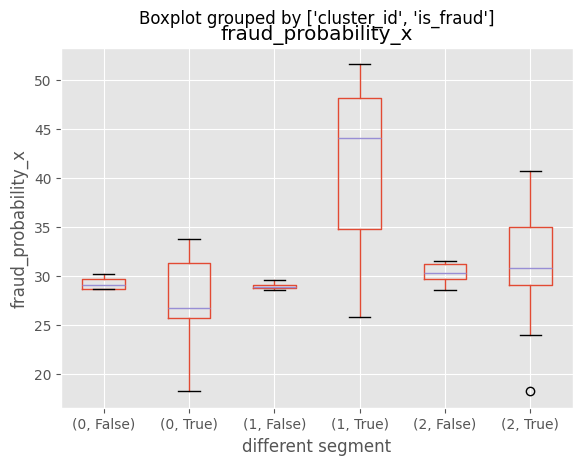

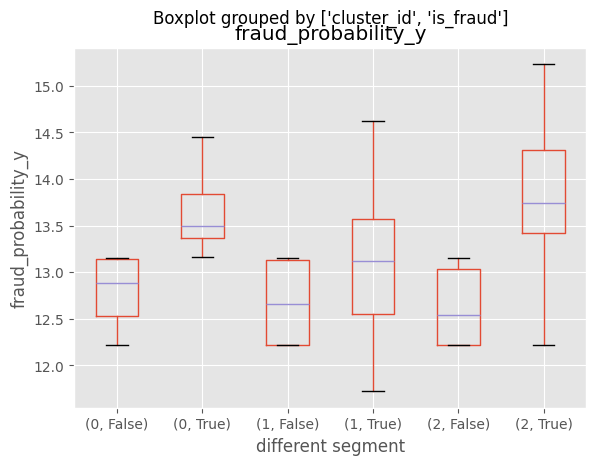

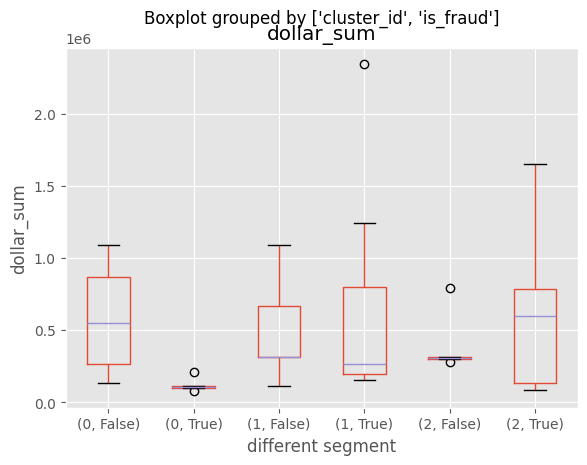

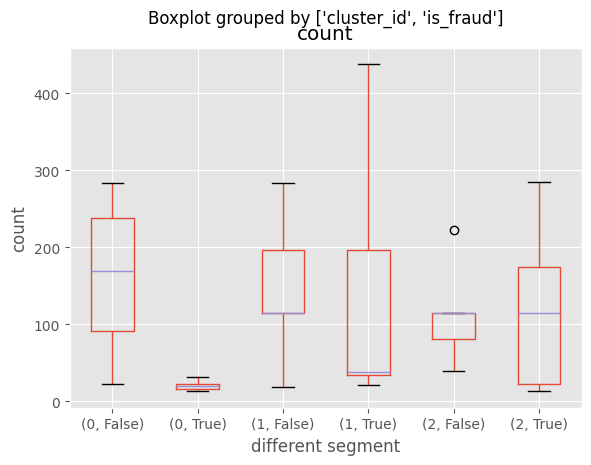

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the data previously labelled with the industry, and note that after the previous weeks of data processing, the current total of remaining alternative industries is 39
merchant_df = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df_new_mid.csv')
print(merchant_df.columns)
# Similar to week8, we construct is_fraud, but here the user's fraud, we don't follow the 50% with the above, we follow the average value of fraud
# when both types of fraud risk are greater than the mean, we consider the business to be at risk of fraud
tmp1 = merchant_df['fraud_probability_x']>merchant_df['fraud_probability_x'].mean()
tmp2 = merchant_df['fraud_probability_y']>merchant_df['fraud_probability_y'].mean()
merchant_df['is_fraud'] = tmp1 | tmp2
df_merchant_1 = merchant_df[merchant_df['cluster_id']==0]
df_merchant_2 = merchant_df[merchant_df['cluster_id']==1]
df_merchant_3 = merchant_df[merchant_df['cluster_id']==2]

# Looking at the different categories for the variables we care about
plt.style.use('ggplot')
def drawfun(df,columns):
    df.boxplot(column=columns, by=['cluster_id','is_fraud'])
    plt.xlabel('different segment')
    plt.ylabel(columns)
    plt.show()

## 1. fruad probability
drawfun(merchant_df,'fraud_probability_x')
drawfun(merchant_df,'fraud_probability_y')
## 2. Transaction amount
drawfun(merchant_df,'dollar_sum')
## 3. number of transactions
drawfun(merchant_df,'count')

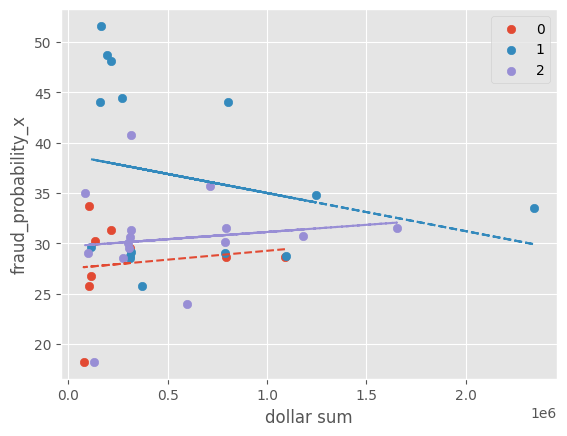

In [2]:
import numpy as np
# the relationship between the probability of fraud and the amount
groups = merchant_df.groupby('cluster_id')
for name, group in groups:
    plt.scatter(group['dollar_sum'], group['fraud_probability_x'], label=name)
    fit = np.polyfit(group['dollar_sum'], group['fraud_probability_x'], 1)
    fit_fn = np.poly1d(fit)
    plt.plot(group['dollar_sum'], fit_fn(group['dollar_sum']), '--')
plt.xlabel('dollar sum')
plt.ylabel('fraud_probability_x')
plt.legend()
plt.show()

1. For merchant with fraud risk, the range of merchant fraud probability values is much larger than that for merchant without its fraud risk, and similarly, such a comparison of the range of probability values is also present in the range of user fraud probability values.
So we favour the merchant with no fraud risk, which means that both merchant fraud and user fraud can be within the predicted controllable range.

2. In different industries, the amount of transactions involved in merchant with fraud risk is not the same in comparison with the amount of transactions in merchant without fraud risk. In categories 2 and 3, the amount of transactions involving merchant without fraud risk is a bit more, while in category 1, it is the amount of merchant without fraud risk that is on the low side. The change in the number of users is very similar to the change in the amount of transactions.

3. the second industry all show that the probability of fraud decreases as the transaction amount rises, these suppliers may be big brands, so less fraud occurs, while industry 1 and industry 3 slightly higher

Comprehensive findings of the above two points, we have to develop different industry sorting rules for different industries

(1) industry category 1 merchants, first in accordance with the amount of sorting from high to bottom, and according to the 1000 for a class, in the same class, will be no risk of fraud merchants in the front.

(2) For Industry Category 2 and Category 3 merchants, first select those with no risk of fraud, sort by transaction amount from highest to lowest, and then among merchants with risk of fraud, sort by amount involved from highest to lowest.

(3) For the overall ranking, we consider the transaction amount more, so when combining all the ranking results, we consolidate them according to the transaction amount.

### step2: Selection top N merchants for different industry

（1） cluster 2 and cluster 3

In [3]:
result3 = df_merchant_3[['merchant_abn','is_fraud','dollar_sum']].sort_values(['is_fraud','dollar_sum'],ascending=[True,False])
result3.head(10)

,merchant_abn,is_fraud,dollar_sum
26,82368304209,False,7.922158e+05
33,93558142492,False,3.133349e+05
35,94493496784,False,3.122255e+05
36,96680767841,False,3.047585e+05
25,80518954462,False,3.017800e+05
34,94311056026,False,2.768089e+05
32,93260930990,True,1.653828e+06
30,90568944804,True,1.178608e+06
24,79827781481,True,7.884611e+05
31,90918180829,True,7.109981e+05


In [4]:
result2 = df_merchant_2[['merchant_abn','is_fraud','dollar_sum']].sort_values(['is_fraud','dollar_sum'],ascending=[True,False])
result2.head(10)

,merchant_abn,is_fraud,dollar_sum
9,27093785141,False,1.094446e+06
4,18158387243,False,7.895213e+05
12,35909341340,False,3.133349e+05
13,39649557865,False,3.123068e+05
7,21439773999,False,3.117716e+05
1,11590404675,False,1.117498e+05
11,31334588839,True,2.345616e+06
6,19492220327,True,1.245489e+06
2,14827550074,True,8.019230e+05
3,15043504837,True,3.720896e+05


In [5]:
# 应用函数到数据框列并创建新列
groups = df_merchant_1.groupby(pd.cut(df_merchant_1['dollar_sum'], bins=[0, 1000, df_merchant_1['dollar_sum'].max(), float('inf')]))
result = pd.DataFrame(columns=df_merchant_1.columns)
for bin_range, group in groups:
    groupnew = group.sort_values('is_fraud', ascending=False)
    result = pd.concat([result,groupnew])

result[['merchant_abn','is_fraud','dollar_sum']].head(10)

/tmp/ipykernel_333/738913301.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df_merchant_1.groupby(pd.cut(df_merchant_1['dollar_sum'], bins=[0, 1000, df_merchant_1['dollar_sum'].max(), float('inf')]))
/tmp/ipykernel_333/738913301.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,groupnew])


,merchant_abn,is_fraud,dollar_sum
17,57564805948,True,2.120915e+05
19,67264251405,True,7.662381e+04
20,72058040180,True,1.027552e+05
21,73052515151,True,1.059777e+05
22,75892370170,True,1.160578e+05
15,48534649627,False,1.089779e+06
16,50315283629,False,7.925567e+05
18,59258669983,False,1.336526e+05
23,76767266140,False,3.114652e+05
